# Reuters Multilabel NLP

In this notebook, I'll explore the Reuters corpus from NLTK using a few different NLP techniques. The corpus is 'multilabel' (which is different from standard 'multiclass'), meaning each article (I'll look at ~1,000) is associated with multiple categories, or tags. This is similar to a blog or website that may have a post classified as 'technology', 'machine learning' and 'natural language processing' simultaneously.

I'll use both Bag of Words and tfidf to create feature spaces to run through both supervised and unsupervised models. Because metrics are difficult for unsupervised multilabel models, I've designed a custom function to evaluate accuracy for training and test sets.

Happy reading!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline
sns.set_style('white')

# Examine the Data

First, let's load up the data and get a feel for how it's organized.

In [2]:
# Let's use articles from the Reuters Corpus.
from nltk.corpus import reuters, stopwords

In [3]:
# We'll choose some categories at random and use those for the rest of our analysis.
np.random.seed(3)
categories = list(np.random.choice(reuters.categories(), 15, replace=False))
print(categories)

['tin', 'coffee', 'gold', 'yen', 'rubber', 'palm-oil', 'lin-oil', 'rape-oil', 'wheat', 'soy-oil', 'nickel', 'cocoa', 'sugar', 'nzdlr', 'sorghum']


In [4]:
# Check that our categories have relatively the same order of magnitude of articles associated with them.
sorted([(len(reuters.fileids(x)), x) for x in categories], reverse=True)

[(283, 'wheat'),
 (162, 'sugar'),
 (139, 'coffee'),
 (124, 'gold'),
 (73, 'cocoa'),
 (59, 'yen'),
 (49, 'rubber'),
 (40, 'palm-oil'),
 (34, 'sorghum'),
 (30, 'tin'),
 (25, 'soy-oil'),
 (9, 'nickel'),
 (8, 'rape-oil'),
 (4, 'nzdlr'),
 (2, 'lin-oil')]

In [5]:
# See how many articles are attached to those categories, the filenames of a few, and total word count.
print('Number of articles:', len(reuters.fileids(categories)))
fileids = reuters.fileids(categories)
print(fileids[:5])
print('Number of total words:', len(reuters.words(fileids)))

Number of articles: 962
['test/14832', 'test/14833', 'test/14840', 'test/14841', 'test/14842']
Number of total words: 227749


Note that in the Reuters corpus, categories are overlapping and each article can be tagged with multiple categories. This may add some complexity to our analysis, but it's also more representative of a real-world NLP project where specific web pages may have multiple topics associated with them.

In [6]:
# We may also be pulling in a lot of other categories in this process because articles can have multiple associations.
# Let's see all the categories we're getting.
all_categories = reuters.categories(fileids)
category_counts = [[len(set(reuters.fileids(x)).intersection(fileids)), x] for x in all_categories]
sorted(category_counts, reverse=True)[:15]

[[311, 'grain'],
 [283, 'wheat'],
 [162, 'sugar'],
 [139, 'coffee'],
 [124, 'gold'],
 [104, 'corn'],
 [73, 'cocoa'],
 [68, 'oilseed'],
 [67, 'veg-oil'],
 [59, 'yen'],
 [56, 'money-fx'],
 [51, 'soybean'],
 [49, 'rubber'],
 [40, 'palm-oil'],
 [36, 'dlr']]

So, we've got a few common categories that we didn't choose explicitly, but which turned out to be popular across the articles that were selected. For instance, 'grain' wasn't in the initial list, but 'wheat' and 'sorghum' are both grains, so it is popular. 'Corn' and 'veg-oil' as well. This should be fine -- it means we may end up clustering by some of these more general categories during unsupervised learning.

In [7]:
# There are three ways we can look at each file: Full text, words, and categories.
# We'll use 'words' for BoW, full text for Tfidf, and categories for classification in both.
print('Raw:\n', reuters.raw('test/14832')[:250])
print('\nWords:\n', reuters.words('test/14832')[:50])
print('\n\nCategories:\n', reuters.categories('test/14832'))

Raw:
 THAI TRADE DEFICIT WIDENS IN FIRST QUARTER
  Thailand's trade deficit widened to 4.5
  billion baht in the first quarter of 1987 from 2.1 billion a
  year ago, the Business Economics Department said.
      It said Janunary/March imports rose to 65.1 

Words:
 ['THAI', 'TRADE', 'DEFICIT', 'WIDENS', 'IN', 'FIRST', 'QUARTER', 'Thailand', "'", 's', 'trade', 'deficit', 'widened', 'to', '4', '.', '5', 'billion', 'baht', 'in', 'the', 'first', 'quarter', 'of', '1987', 'from', '2', '.', '1', 'billion', 'a', 'year', 'ago', ',', 'the', 'Business', 'Economics', 'Department', 'said', '.', 'It', 'said', 'Janunary', '/', 'March', 'imports', 'rose', 'to', '65', '.']


Categories:
 ['corn', 'grain', 'rice', 'rubber', 'sugar', 'tin', 'trade']


## Clean the Data

Because we're already given a method for accessing individual words, we'll have a bit less data cleaning to do.

In [8]:
# Create a list with each article as an element.
articles = [reuters.raw(x) for x in fileids]
print('Before:', articles[5][:200], '\n')

# Let's make them all lowercase and remove white space.
articles = [' '.join(x.split()).lower() for x in articles]
print('After:', articles[5][:200], '\n')

# And grabbing categories by article.
categories_by_article = [reuters.categories(x) for x in fileids]
print(categories_by_article[:5])

Before: SUBROTO SAYS INDONESIA SUPPORTS TIN PACT EXTENSION
  Mines and Energy Minister Subroto
  confirmed Indonesian support for an extension of the sixth
  International Tin Agreement (ITA), but said a new  

After: subroto says indonesia supports tin pact extension mines and energy minister subroto confirmed indonesian support for an extension of the sixth international tin agreement (ita), but said a new pact w 

[['corn', 'grain', 'rice', 'rubber', 'sugar', 'tin', 'trade'], ['palm-oil', 'veg-oil'], ['coffee', 'lumber', 'palm-oil', 'rubber', 'veg-oil'], ['grain', 'wheat'], ['gold']]


That should be enough for the raw text, let's just touch up the 'Words' lists by making lowercase and removing punctuation, as we won't be using that for BoW. Instead of grabbing all the punctuation separately, I'll just get rid of all words length 2 or less and all stopwords. This will also deal with some common words and numbers and make our data a little easier to wrangle.

In [9]:
# Make a list of all the words in each article.
words_by_article = [reuters.words(x) for x in fileids]
print('Before:', words_by_article[5][:25])
print('Total Words:', sum([len(x) for x in words_by_article]), '\n')

# A set of stopwords will be faster to search through.
stopword_set = set(stopwords.words('english'))
for i, words in enumerate(words_by_article):
    words_by_article[i] = [x.lower() for x in words if (len(x) > 2) and not (x in stopword_set)]
print('After:', words_by_article[5][:25])
print('Total Words:', sum([len(x) for x in words_by_article]))

Before: ['SUBROTO', 'SAYS', 'INDONESIA', 'SUPPORTS', 'TIN', 'PACT', 'EXTENSION', 'Mines', 'and', 'Energy', 'Minister', 'Subroto', 'confirmed', 'Indonesian', 'support', 'for', 'an', 'extension', 'of', 'the', 'sixth', 'International', 'Tin', 'Agreement', '(']
Total Words: 227749 

After: ['subroto', 'says', 'indonesia', 'supports', 'tin', 'pact', 'extension', 'mines', 'energy', 'minister', 'subroto', 'confirmed', 'indonesian', 'support', 'extension', 'sixth', 'international', 'tin', 'agreement', 'ita', 'said', 'new', 'pact', 'necessary', 'asked']
Total Words: 119008


Nice, we've cut out nearly half the words from our data set that were unlikely to be useful. This should make things go faster from here on out.

# Bag of Words

Are we going to use lemmas, etc for this analysis? It's a bit slow and we've already got a nice clean set of words. Let's see how we do without getting into spaCy first, and add it if it seems useful. (Note: it turned out not to be necessary)

## Setting Up BoW

First we'll build our Bag of Words by finding the most common words and counting them up in each article.

In [10]:
from collections import Counter
import itertools

In [11]:
# Put all the strings into a single list.
allwords = [word for article in words_by_article for word in article]

# Count 'em up.
words_counted = Counter(allwords)

# Which words are most common?
print(words_counted.most_common(25))

[('said', 3481), ('the', 1749), ('tonnes', 1535), ('mln', 1331), ('000', 1176), ('wheat', 961), ('year', 814), ('sugar', 731), ('pct', 713), ('would', 682), ('coffee', 650), ('last', 616), ('1986', 578), ('export', 539), ('market', 539), ('dlrs', 537), ('prices', 527), ('gold', 518), ('new', 512), ('price', 442), ('trade', 425), ('may', 408), ('production', 391), ('cocoa', 376), ('producers', 363)]


Some of these words aren't great to have in our set. Let's remove some by hand, and then remove words that occur less than 3 times.

In [12]:
# Make a list of words to ignore, then cycle through the counter to remove them.
ignore = ['said', 'the', '000', 'year', 'pct', 'may']
for word in list(words_counted):
    if word in ignore:
        del words_counted[word]
print(words_counted.most_common(25))
print('Unique words:', len(list(words_counted)))

[('tonnes', 1535), ('mln', 1331), ('wheat', 961), ('sugar', 731), ('would', 682), ('coffee', 650), ('last', 616), ('1986', 578), ('export', 539), ('market', 539), ('dlrs', 537), ('prices', 527), ('gold', 518), ('new', 512), ('price', 442), ('trade', 425), ('production', 391), ('cocoa', 376), ('producers', 363), ('nil', 361), ('1987', 358), ('week', 351), ('one', 347), ('per', 347), ('stock', 346)]
Unique words: 9750


In [13]:
# We'll use itertools to delete all items that are not dropped by this lambda function.
for key, count in itertools.dropwhile(lambda key_count: key_count[1] >= 5, words_counted.most_common()):
    del words_counted[key]
print('Least common words:', words_counted.most_common()[::-1][:5])    
print('Unique words:', len(list(words_counted)))

Least common words: [('lechin', 5), ('arbitration', 5), ('awf', 5), ('martell', 5), ('citicorp', 5)]
Unique words: 3333


That's a bit better. Let's go ahead and make of DataFrame for modeling.

In [14]:
# Create a DataFrame, include article text, categories, and features for all the words in our list.
df_bow = pd.DataFrame(columns=['article_text', 'categories'] + list(words_counted))
df_bow['article_text'] = articles
df_bow['categories'] = categories_by_article
df_bow.fillna(0, inplace=True)
df_bow.head(3)

,article_text,categories,thai,trade,deficit,first,quarter,thailand,billion,1987,...,nogales,awf,amselco,amt,arbitration,lechin,otsuki,miti,iwc,witte
0,thai trade deficit widens in first quarter tha...,"[corn, grain, rice, rubber, sugar, tin, trade]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,indonesia sees cpo price rising sharply indone...,"[palm-oil, veg-oil]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,indonesian commodity exchange may expand the i...,"[coffee, lumber, palm-oil, rubber, veg-oil]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And finally, we'll populate the word counts.

In [15]:
# Make a set of the feature names for faster searching.
features_set = set(words_counted)

# Iterate through the words in each article to add values to our DataFrame.
for i, article in enumerate(words_by_article):
    counter = Counter(article)
    for key, count in counter.most_common():
        if key in features_set:
            df_bow.loc[i, key] = count
            
df_bow.head(5)

,article_text,categories,thai,trade,deficit,first,quarter,thailand,billion,1987,...,nogales,awf,amselco,amt,arbitration,lechin,otsuki,miti,iwc,witte
0,thai trade deficit widens in first quarter tha...,"[corn, grain, rice, rubber, sugar, tin, trade]",1,2,2,4,4,2,6,1,...,0,0,0,0,0,0,0,0,0,0
1,indonesia sees cpo price rising sharply indone...,"[palm-oil, veg-oil]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,indonesian commodity exchange may expand the i...,"[coffee, lumber, palm-oil, rubber, veg-oil]",0,3,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,sri lanka gets usda approval for wheat price f...,"[grain, wheat]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,western mining to open new gold mine in austra...,[gold],0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Sanity check -- did we get everything counted?
print('"Trade" added up over the DataFrame:', df_bow['trade'].sum())
print('"Trade" from our original "words_counted" counter:', words_counted['trade'])

"Trade" added up over the DataFrame: 425
"Trade" from our original "words_counted" counter: 425


## Supervised BoW Model

We're ready to begin modeling! We still have to create our X and y matrices and split the data into training and testing. We'll have to transform our outcome variable, y, into a binary array of multilabel outputs.

In [17]:
print('df shape:', df_bow.shape)
df_bow.head(2)

df shape: (962, 3335)


,article_text,categories,thai,trade,deficit,first,quarter,thailand,billion,1987,...,nogales,awf,amselco,amt,arbitration,lechin,otsuki,miti,iwc,witte
0,thai trade deficit widens in first quarter tha...,"[corn, grain, rice, rubber, sugar, tin, trade]",1,2,2,4,4,2,6,1,...,0,0,0,0,0,0,0,0,0,0
1,indonesia sees cpo price rising sharply indone...,"[palm-oil, veg-oil]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


How will we treat the outcome variable, 'categories'? We don't really want to look at all the extra (50+) categories we pulled in implicitly, so let's narrow it down to just the set of 15 original categories.

In [18]:
# This is our list of original categories.
print(categories)
categories_set = set(categories)

['tin', 'coffee', 'gold', 'yen', 'rubber', 'palm-oil', 'lin-oil', 'rape-oil', 'wheat', 'soy-oil', 'nickel', 'cocoa', 'sugar', 'nzdlr', 'sorghum']


In [19]:
# Let's search through of 'categories' feature and see what matches up with those from the original group.
categories_reduced = [list(categories_set.intersection(df_bow['categories'][index])) for index in df_bow.index]
print(categories_reduced[:5])

# Create a new feature in our DF.
df_bow['categories_reduced'] = categories_reduced

[['rubber', 'sugar', 'tin'], ['palm-oil'], ['rubber', 'palm-oil', 'coffee'], ['wheat'], ['gold']]


Okay, we've gotten rid of all the extra categories, but many articles still have multiple associations. It turns out Random Forest, Decision Tree, KNN, and MLP already support multilabel output, although metrics won't work for them. 

http://scikit-learn.org/stable/modules/multiclass.html

Let's just run it on the reduced category set and see what happens. We do have to binarize our multilabel output.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix

In [21]:
mlb = MultiLabelBinarizer()

# We have to exclude the category features we've been building.
X = df_bow.loc[:, ~df_bow.columns.isin(['article_text', 'categories', 'categories_reduced'])]
y = mlb.fit_transform(df_bow.categories_reduced)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)
y_labels_train, y_labels_test = train_test_split(df_bow.categories_reduced, test_size=0.25, random_state=100)
y_full_train, y_full_test = train_test_split(df_bow.categories, test_size=0.25, random_state=100)
articles_train, articles_test = train_test_split(df_bow.article_text, test_size=0.25, random_state=100)
print('Array shapes:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Array shapes: (721, 3333) (241, 3333) (721, 15) (241, 15)


### Running Models

In [22]:
# Run Random Forest.
rfc = RandomForestClassifier().fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# Print out results for the test and predicted sets.
print('(Test set) (Model predictions)\n')
print(np.stack([mlb.inverse_transform(y_test), mlb.inverse_transform(y_pred)], axis=1)[:20])

(Test set) (Model predictions)

[[('wheat',) ('wheat',)]
 [('palm-oil',) ()]
 [('coffee',) ()]
 [('cocoa',) ()]
 [('wheat',) ('wheat',)]
 [('sugar',) ('sugar',)]
 [('sugar',) ()]
 [('cocoa',) ('cocoa',)]
 [('wheat',) ('wheat',)]
 [('sorghum',) ()]
 [('gold',) ('gold',)]
 [('rape-oil',) ()]
 [('sugar',) ()]
 [('wheat',) ('wheat',)]
 [('wheat',) ('wheat',)]
 [('wheat',) ('wheat',)]
 [('gold',) ('gold',)]
 [('sorghum',) ()]
 [('coffee',) ('coffee',)]
 [('sugar',) ('sugar',)]]


It looks like we're doing really well, but this isn't a very analytical way to rate our model. The biggest issue seems to be in not predicting any category in certain cases rather than mislabeling. We can use 'score', but keep in mind this will be 'subset accuracy', which means every label must be predicted correctly for the example to count. This is a harsh measure, so we don't expect our accuracy to be perfect.

In [23]:
print('Training set score:', rfc.score(X_train, y_train))
print('Test set score:', rfc.score(X_test, y_test))

Training set score: 0.959778085992
Test set score: 0.647302904564


We're overfitting the training set, but it's possible that 0.64 isn't so bad on the test set, since we're looking at subset accuracy. Let's see if we can do better with this or other models, and for now we'll just use 'score' to measure effectiveness.

In [24]:
# These are the models that support multilabel output.
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

#### Multi Layer Perceptron

In [25]:
mlp_params = {'hidden_layer_sizes':[(200,), (30, 30,), (60, 60,)]}
mlp_grid = GridSearchCV(MLPClassifier(), param_grid=mlp_params, cv=5).fit(X_train, y_train)
print('Best GridSearchCV params:', mlp_grid.best_params_)
print('Training set average cv score w/best parameters:', mlp_grid.best_score_)
print('Test set score w/best parameters:', mlp_grid.score(X_test, y_test))

/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimizati

Best GridSearchCV params: {'hidden_layer_sizes': (200,)}
Training set average cv score w/best parameters: 0.775312066574
Test set score w/best parameters: 0.796680497925


#### Random Forest

In [26]:
rfc_params = {'max_depth':[10, 30, None],
              'n_estimators':[10, 30, 100]}
rfc_grid = GridSearchCV(RandomForestClassifier(), param_grid=rfc_params, cv=5).fit(X_train, y_train)
print('Best GridSearchCV params:', rfc_grid.best_params_)
print('Training set average cv score w/best parameters:', rfc_grid.best_score_)
print('Test set score w/best parameters:', rfc_grid.score(X_test, y_test))

Best GridSearchCV params: {'max_depth': None, 'n_estimators': 100}
Training set average cv score w/best parameters: 0.775312066574
Test set score w/best parameters: 0.788381742739


#### Decision Tree

In [27]:
dtc_params = {'max_depth':[10, 30, None],
              'min_samples_split':[2, 4, 8]}
dtc_grid = GridSearchCV(DecisionTreeClassifier(), param_grid=dtc_params, cv=5).fit(X_train, y_train)
print('Best GridSearchCV params:', dtc_grid.best_params_)
print('Training set average cv score w/best parameters:', dtc_grid.best_score_)
print('Test set score w/best parameters:', dtc_grid.score(X_test, y_test))

Best GridSearchCV params: {'max_depth': 30, 'min_samples_split': 4}
Training set average cv score w/best parameters: 0.914008321775
Test set score w/best parameters: 0.896265560166


#### K Nearest Neighbors

In [28]:
knc_params = {'n_neighbors':[2, 4, 8, 16]}
knc_grid = GridSearchCV(KNeighborsClassifier(), param_grid=knc_params, cv=5).fit(X_train, y_train)
print('Best GridSearchCV params:', knc_grid.best_params_)
print('Training set average cv score w/best parameters:', knc_grid.best_score_)
print('Test set score w/best parameters:', knc_grid.score(X_test, y_test))

Best GridSearchCV params: {'n_neighbors': 4}
Training set average cv score w/best parameters: 0.631067961165
Test set score w/best parameters: 0.655601659751


It looks like Decision Tree is doing the best -- even better than Random Forest. Interesting! 90% subset accuracy on the test set is quite remarkable. Let's try some unsupervised techniques.

## Unsupervised BoW Model

What if we try out some unsupervised models? The overlapping outcomes may cause some issues around the borders, but let's see what happens.

In [29]:
from sklearn.cluster import KMeans, MeanShift, SpectralClustering, AffinityPropagation, estimate_bandwidth
from sklearn.decomposition import TruncatedSVD, PCA

In [36]:
# Run KMeans and grab the labels for training and test sets.
n_clusters=10
km = KMeans(n_clusters=n_clusters).fit(X_train)
km_labels_train = km.labels_
km_labels_test = km.predict(X_test)

### Creating an Evaluation Metric

We're going to need a way to measure how well our clustering algorithm is doing, and there isn't an out-of-the-box solution for this one. I'm going to build an evaluator to take each cluster, determine which category is most common for the items in the cluster, and show how strongly that category dominates (simple percentages should be fine), and show the number of items in that cluster. 

In [37]:
# Function which outputs all the category labels for each cluster.
# Takes input of the model_clusters, which is the result of model.labels_,
# and true_labels, which is the categorical labels from y_train.
#
# Output is a dictionary with all the category labels for each cluster.

def label_clusters(model_labels, true_labels):
    # Create a dictionary.
    clust_dict = {}
    
    # Set up each cluster as a key in the dictionary.
    for label in set(model_labels):
        clust_dict[label]=[]
    
    # Cycle through each example and append all the words to each key.
    for i in range(len(model_labels)):
        clust_dict[list(model_labels)[i]].append(list(true_labels)[i])
    
    # Make each key a list of strings rather than a list of lists.
    for key in clust_dict.keys():
        clust_dict[key]=[x[0] for x in clust_dict[key]]
    
    return clust_dict

In [38]:
# Here's an example of how it works.
clust_dict = label_clusters(km_labels_train, y_labels_train)
print(clust_dict[1])

['sorghum', 'wheat', 'sorghum', 'sorghum', 'sorghum']


In [39]:
# Function to find the most common label in a list.

def find_common(lst):
    return max(set(lst), key=lst.count)

In [40]:
# It works.
find_common(clust_dict[1])

'sorghum'

In [41]:
# Function to return evaluation metrics from a list.

def eval_list(lst, disp=True):
    if disp:
        print('Most common:', find_common(lst), 
              '\nTotal most common:', lst.count(find_common(lst)), 
              '\nTotal all items:', len(lst))
    return [find_common(lst), 
            lst.count(find_common(lst)), 
            len(lst), 
            float(format(lst.count(find_common(lst))/len(lst), '.2f'))]

In [42]:
# Here's how it works.
eval_list(clust_dict[1])

Most common: sorghum 
Total most common: 4 
Total all items: 5


['sorghum', 4, 5, 0.8]

In [43]:
# Function to evaluate each cluster in a model.
# Same inputs as label_clusters.
# To run test set simultaneously (it uses the label from the training set), 
# include model_labels_test and true_labels_test.
#
# For large numbers of clusters, you may want show_clusters=False.
#
# Output is the percentage of points which are in a cluster where they are the most common element.

def evaluate_clusters(model_labels, true_labels, model_labels_test=[], true_labels_test=[], show_clusters=True):
    # Run the labeling function.
    clust_dict = label_clusters(model_labels, true_labels)
    
    # Label the test set if provided.
    if not true_labels_test is []:
        clust_dict_test = label_clusters(model_labels_test, true_labels_test)
    
    # Keep track of how many points are well-labeled.
    n_correct = 0
    n_total = 0
    n_correct_test = 0
    n_total_test = 0
    
    # Tally for each key.
    for key in clust_dict.keys():
        
        # Run our eval function
        [label_common, n_common, n_all, common_pct] = eval_list(clust_dict[key], disp=False)
        if show_clusters:
            print([label_common, common_pct, n_all])
        
        # Add the correctly classified and total points to our tally.
        n_correct += n_common
        n_total += n_all
        
        # Add the correctly labeled test set results.
        if not true_labels_test is []:
            if not key in clust_dict_test.keys():
                clust_dict_test[key] = []
            n_correct_test += clust_dict_test[key].count(label_common)
            n_total_test += len(clust_dict_test[key])
   
    return [n_correct/n_total, n_correct_test/n_total_test] if n_total_test else n_correct/n_total

In [44]:
evaluate_clusters(km_labels_train, y_labels_train, km_labels_test, y_labels_test)

['sugar', 1.0, 7]
['sorghum', 0.8, 5]
['soy-oil', 1.0, 1]
['gold', 0.61, 28]
['wheat', 0.3, 557]
['coffee', 1.0, 38]
['cocoa', 0.73, 15]
['wheat', 0.65, 57]
['yen', 0.92, 12]
['soy-oil', 1.0, 1]


[0.40499306518723993, 0.4190871369294606]

Great! We now have an intuitive method for evaluating our clusters. Specifically, evaluate_clusters takes the output from our model, compares it to the category labels from our data set, and returns the percentage of examples which are in a cluster where they are the most common element. So with 1 cluster of three elements, if 2 elements are the same, the score would be 0.67. A more complicated example would be:

    Cluster 0: [X, X, Y, Y, Y]
    Cluster 1: [Z, Y, X, X]
    
This example would have a score of 

    (3+2)/(5+4) = .56
    
Or in words,
    
    (#correct from cluster 0 + #correct from cluster 1)/(total # cluster 0 + total # cluster 1)
    
Note that for multilabeled data, it is impossible to achieve a score of 1.0 because some clusters are required to include labels that are not the most common. 

The "test set" output is the same metric, but using the common label from the training set rather than the test set. 

Let's see how some models do.

### Running Unsupervised BoW Models

Let's start with some different numbers of clusters for KMeans.

#### KMeans

In [45]:
for n in [2, 4, 8, 16, 32, 64, 128]:
    km = KMeans(n_clusters=n).fit(X_train)
    km_labels_train = km.labels_
    km_labels_test = km.predict(X_test)
    print('{} Clusters:'.format(n), evaluate_clusters(km_labels_train, 
                                                      y_labels_train, 
                                                      km_labels_test, 
                                                      y_labels_test,
                                                      show_clusters=False))

2 Clusters: [0.2843273231622746, 0.2863070539419087]
4 Clusters: [0.2857142857142857, 0.2863070539419087]
8 Clusters: [0.3606102635228849, 0.38589211618257263]
16 Clusters: [0.4798890429958391, 0.4896265560165975]
32 Clusters: [0.5533980582524272, 0.5394190871369294]
64 Clusters: [0.6477115117891817, 0.5892116182572614]
128 Clusters: [0.8183079056865464, 0.7385892116182573]


So, we do better and better as we increase the number of clusters, but we don't want to overfit the data by giving every sentence its own cluster. We have 15 different categories which are possible outputs, so I think it's fair to stick with 32 clusters. There is also a fair amount of variation between runs. Let's see how our clusters were defined.

In [46]:
n_clusters=32
km = KMeans(n_clusters=n_clusters).fit(X_train)
km_labels_train = km.labels_
print('{} Clusters:'.format(n_clusters), evaluate_clusters(km_labels_train, y_labels_train, show_clusters=True))

['soy-oil', 0.5, 2]
['sugar', 1.0, 30]
['soy-oil', 1.0, 1]
['gold', 0.95, 66]
['cocoa', 0.82, 11]
['soy-oil', 1.0, 1]
['rubber', 1.0, 3]
['coffee', 0.97, 58]
['rubber', 0.8, 15]
['cocoa', 1.0, 8]
['wheat', 0.63, 19]
['yen', 0.83, 30]
['sugar', 1.0, 1]
['coffee', 1.0, 11]
['wheat', 0.28, 317]
['sugar', 1.0, 3]
['coffee', 1.0, 2]
['soy-oil', 1.0, 1]
['sorghum', 1.0, 4]
['cocoa', 1.0, 1]
['palm-oil', 1.0, 1]
['wheat', 0.61, 67]
['yen', 1.0, 1]
['wheat', 0.98, 57]
['wheat', 1.0, 1]
['coffee', 1.0, 2]
['tin', 1.0, 1]
['gold', 1.0, 2]
['gold', 1.0, 2]
['sugar', 1.0, 1]
['sugar', 1.0, 1]
['wheat', 1.0, 1]
32 Clusters: 0.6158113730929264


Like our initial example of 10 clusters, we continue to have one large cluster with very poor separation, and a lot of clusters that are only one example. Let's try some other models.

#### MeanShift

In [47]:
bandwidth = estimate_bandwidth(X_train, quantile=0.5, n_samples=500)

ms = MeanShift(bandwidth=bandwidth).fit(X_train)
ms_labels_train = ms.labels_
ms_labels_test = ms.predict(X_test)
n_clusters = ms.cluster_centers_.shape[0]

print('{} Clusters:'.format(n_clusters), evaluate_clusters(ms_labels_train, 
                                                           y_labels_train, 
                                                           ms_labels_test, 
                                                           y_labels_test, 
                                                           show_clusters=True))

['wheat', 0.3, 603]
['coffee', 1.0, 2]
['yen', 1.0, 2]
['yen', 1.0, 2]
['yen', 1.0, 2]
['gold', 1.0, 2]
['cocoa', 1.0, 1]
['tin', 1.0, 1]
['coffee', 1.0, 1]
['wheat', 1.0, 1]
['cocoa', 1.0, 3]
['sugar', 1.0, 1]
['coffee', 1.0, 1]
['yen', 1.0, 1]
['sugar', 1.0, 1]
['soy-oil', 1.0, 1]
['sorghum', 1.0, 1]
['yen', 1.0, 1]
['yen', 1.0, 1]
['coffee', 1.0, 1]
['sugar', 1.0, 1]
['wheat', 1.0, 1]
['sugar', 1.0, 1]
['wheat', 1.0, 1]
['wheat', 1.0, 1]
['cocoa', 1.0, 1]
['wheat', 1.0, 1]
['cocoa', 1.0, 1]
['nzdlr', 1.0, 1]
['cocoa', 1.0, 1]
['wheat', 1.0, 1]
['wheat', 1.0, 1]
['rubber', 1.0, 1]
['coffee', 1.0, 1]
['tin', 1.0, 1]
['sugar', 1.0, 1]
['nzdlr', 1.0, 1]
['palm-oil', 1.0, 1]
['sugar', 1.0, 1]
['coffee', 1.0, 1]
['wheat', 1.0, 1]
['sugar', 1.0, 1]
['sugar', 1.0, 1]
['wheat', 1.0, 1]
['coffee', 1.0, 1]
['wheat', 0.67, 3]
['wheat', 1.0, 1]
['tin', 1.0, 1]
['yen', 1.0, 1]
['sugar', 1.0, 1]
['coffee', 1.0, 1]
['rubber', 1.0, 2]
['wheat', 1.0, 1]
['sugar', 1.0, 1]
['wheat', 1.0, 1]
['gold', 1.

Yuck -- this just chose a bunch of single points to classify and left almost everything else in a single cluster. Even so it does really badly -- evaluation of 0.41 on training and 0.34 on test.

#### Spectral Clustering

In [48]:
for n in [4, 8, 16]:
    sc = SpectralClustering(n_clusters=n).fit(X_train)
    sc_labels_train = sc.labels_
    print('{} Clusters:'.format(n), evaluate_clusters(sc_labels_train, 
                                                      y_labels_train,
                                                      show_clusters=True))

/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


['wheat', 0.29, 697]
['gold', 0.5, 8]
['wheat', 0.5, 8]
['gold', 0.25, 8]
4 Clusters: 0.289875173370319
['wheat', 0.29, 697]
['yen', 0.5, 4]
['gold', 1.0, 2]
['yen', 0.33, 6]
['wheat', 1.0, 2]
['wheat', 0.5, 2]
['gold', 1.0, 4]
['gold', 1.0, 4]
8 Clusters: 0.29958391123439665


LinAlgError: 13-th leading minor not positive definite

So, I don't know what's going wrong here. Spectral Clustering is failing on certain runs, but not always. Maybe some peculiarity in the data? It's also not doing great with only a handful of clusters, so let's move on.

#### Affinity Propagation

In [49]:
ap = AffinityPropagation(damping=0.5).fit(X_train)
ap_labels_train = ap.labels_
ap_labels_test = ap.predict(X_test)
n_clusters = ap.cluster_centers_.shape[0]

print('{} Clusters:'.format(n_clusters), evaluate_clusters(ap_labels_train, 
                                                           y_labels_train, 
                                                           ap_labels_test, 
                                                           y_labels_test, 
                                                           show_clusters=False))

151 Clusters: [0.6754507628294036, 0.5809128630705395]


Well, this score (0.68 training, 0.58 test) is pretty good, but we're creating way too many clusters (151) and overfitting. For reference, when we allowed 128 clusters for KMeans, our training and test values were 0.78 and 0.73, respectively.

Overall, I'd say KMeans is doing the best. We're able to control the number of clusters to prevent overfitting, and we're getting the highest evaluation score with fewer clusters than the other algorithms. I do think somewhere around 30-50 clusters is the sweet spot of maximizing accuracy without overfitting too much.

Moving on!

### LSA with BoW

How about Latent Semantic Analysis with our Bag of Words?

In [50]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [51]:
# Build and fit our decomposition model. 
# Let's use 30 components to maintain consistency with our other models.
n_components = 30
svd = TruncatedSVD(n_components)
lsa = make_pipeline(svd, Normalizer(copy=False))

X_train_lsa = lsa.fit_transform(X_train)

print('Variance explained with {} components:'.format(n_components), svd.explained_variance_ratio_.sum())

Variance explained with 30 components: 0.634343282326


In [52]:
# Make a Dataframe with categories as indices and components as features
categories_by_component=pd.DataFrame(X_train_lsa,index=y_labels_train)
categories_by_component.shape

# Show the highest values for a few components, along with their articles
for i in range(10):
    print('Component {}:'.format(i))
    print(categories_by_component.loc[:,i].sort_values(ascending=False)[0:5])

Component 0:
categories_reduced
[soy-oil, sorghum]    0.998767
[coffee]              0.986346
[coffee]              0.984629
[coffee]              0.971175
[sugar]               0.970083
Name: 0, dtype: float64
Component 1:
categories_reduced
[wheat]    0.815419
[sugar]    0.814558
[wheat]    0.810298
[sugar]    0.786852
[sugar]    0.774277
Name: 1, dtype: float64
Component 2:
categories_reduced
[wheat]                      0.460702
[soy-oil, wheat, sorghum]    0.432821
[wheat]                      0.427429
[wheat]                      0.422798
[wheat]                      0.422784
Name: 2, dtype: float64
Component 3:
categories_reduced
[wheat]                      0.696778
[soy-oil, wheat, sorghum]    0.684417
[soy-oil, wheat]             0.478858
[gold]                       0.333036
[soy-oil]                    0.328951
Name: 3, dtype: float64
Component 4:
categories_reduced
[cocoa]    0.717628
[cocoa]    0.716989
[cocoa]    0.689478
[cocoa]    0.677542
[cocoa]    0.663771
Name: 4, 

This is great! Many of these components are excellent. I'm curious about components 0 and 1 -- they have very high scores, but different categories. Maybe there is some other similarity in the text? Let's look.

In [53]:
articles_by_component=pd.DataFrame(X_train_lsa,index=articles_train)
articles_by_component.shape

for i in range(2):
    print('Component {}:'.format(i))
    print(articles_by_component.loc[:,i].sort_values(ascending=False)[0:5])

Component 0:
article_text
net change in export commitments -- usda the u.s. agriculture department gave the net change in export commitments, including sales, cancellations, foreign purchases and cumulative exports, in the current seasons through the week ended april 2, with comparisons, as follows, in tonnes, except as noted -- 4/2/87 prev week all wheat 119,800 368,300 corn 1,001,900 927,000 soybeans 240,500 300,900 soy cake/meal 117,700 170,200 soybean oil 2,400-x 8,100 cotton-y 60,200 31,900 x-minus total. y-running bales. the indicated totals include reported commitments to both named and unnamed destinations, sales on exporters' own account and optional origin sales plus actual exports already made during the respective marketing seasons. the usda cautions that reported outstanding sales are subject to modification, deferral or cancellation and it is unlikely that all reported quantities will be exported. usda gave detailed breakdowns for the 1986/87 and 1987/88 seasons as follow

Ah -- so Component 0 is full of production reports that contain the word 'nil' numerous times. Component 1 seems to talk about production and tonnes quite a bit. It is understandable that there would be a lot of crossover in terms for some of these similar commodity-related categories. 

This may actually be our most effective unsupervised method thus far. Let's see how we do with tfidf!

# Tfidf

Let's see if we can do better than our Bag of Words by using tfidf. It's likely this will get rid of some of the noise we were seeing in our LSA.

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [56]:
# Create the model, fit, and transform the original articles. Each article is one row.

vectorizer = TfidfVectorizer(max_df=0.4,
                             min_df=10,
                             stop_words='english',
                             lowercase=True,
                             ngram_range=(1, 2),
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True)

articles_tfidf = vectorizer.fit_transform(articles)
print('Number of Articles and Features:', articles_tfidf.get_shape())

Number of Articles and Features: (962, 2003)


I've tuned the model to run well, particularly with max_df, min_df, and ngram_range.

In [57]:
# Split Tfidf results into train and test.
X_tfidf_train, X_tfidf_test = train_test_split(articles_tfidf, test_size=0.25, random_state=100)

# Make a version we can read.
X_tfidf_train_csr = X_tfidf_train.tocsr()

# Number of training articles
n = X_tfidf_train.get_shape()[0]

# A list of dictionaries, one per paragraph
tfidf_byarticle = [{} for _ in range(0,n)]

# List of features
terms = vectorizer.get_feature_names()

# For each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_tfidf_train_csr.nonzero()):
    tfidf_byarticle[i][terms[j]] = X_tfidf_train_csr[i, j]
    
print('Original Article:\n', articles_train[5][:300], '...')
print('\n\nTfidf Vector:\n', tfidf_byarticle[5])
print('\n\nOriginal Categories:\n', y_labels_train[5])

Original Article:
 subroto says indonesia supports tin pact extension mines and energy minister subroto confirmed indonesian support for an extension of the sixth international tin agreement (ita), but said a new pact was not necessary. asked by reuters to clarify his statement on monday in which he said the pact shou ...


Tfidf Vector:
 {'non members': 0.12324648290357955, 'intermediate': 0.12510600952205911, 'icco council': 0.11568637363883798, 'ends': 0.12324648290357955, 'council meeting': 0.1132386717919496, 'different': 0.10542185626231504, 'differentials': 0.11210519428187977, 'cocoa agreement': 0.11842267150249437, 'nearby': 0.10900303561927323, 'organization icco': 0.10231969759970849, 'cocoa organization': 0.10091128574959078, 'organization': 0.07778581918204501, 'icco': 0.19091113475812635, 'operations': 0.21084371252463008, 'reports': 0.099583399736052097, 'day': 0.084469157201609746, 'offer': 0.083480425833266203, 'fixed': 0.10626673775561681, 'limited': 0.102319697599708

#### LSA with Tfidf

In [58]:
# Build and fit our decomposition model. 
# We can alter the number of components until we're happy with our explained variance.
n_components = 100
svd = TruncatedSVD(n_components)
lsa = make_pipeline(svd, Normalizer(copy=False))

X_train_lsa = lsa.fit_transform(X_tfidf_train)

print('Variance explained with {} components:'.format(n_components), svd.explained_variance_ratio_.sum())

Variance explained with 100 components: 0.544893519624


In [59]:
# Make a Dataframe with articles as indices and components as features
articles_by_component=pd.DataFrame(X_train_lsa,index=articles_train)
articles_by_component.shape

# Show the highest values for a few components, along with their articles
for i in range(2):
    print('Component {}:'.format(i))
    print(articles_by_component.loc[:,i].sort_values(ascending=False)[0:4])

Component 0:
article_text
pakistan not seen as major wheat exporter pakistan is not emerging as a major wheat exporter as world market prospects are not good enough, sartaj aziz, special assistant on food and agriculture to the pakistani prime minister, said in an interview. no exports are planned for the next 12 months or so and plans last year to sell one mln tonnes to iran came to nothing because they could not agree a price, he said. aziz forecast that pakistan may have exportable surpluses of one mln tonnes or a half mln tonnes over the next few harvests in years when the weather is favourable. the government does not wish to increase output much above this because of low world prices, and the land would be better used for other crops. aziz said the pakistani government does not want area sown to wheat to increase from the current seven mln hectares. some 10 pct of that area which gives low yields could be switched to more profitable crops such as oilseeds. the aim is to concentra

That's cool, but it would be easier to see how we're doing if we looked at the 'Category' labels like we did with BoW.

In [60]:
# Make a Dataframe with categories as indices and components as features
categories_by_component=pd.DataFrame(X_train_lsa,index=y_labels_train)
categories_by_component.shape

# Show the highest values for a few components, along with their articles
for i in range(20):
    print('Component {}:'.format(i))
    print(categories_by_component.loc[:,i].sort_values(ascending=False)[0:5])

Component 0:
categories_reduced
[wheat]                                       0.593285
[sugar]                                       0.589723
[cocoa, coffee, wheat, sugar, rubber, tin]    0.557614
[wheat]                                       0.557178
[wheat]                                       0.549394
Name: 0, dtype: float64
Component 1:
categories_reduced
[coffee]    0.633773
[coffee]    0.613990
[coffee]    0.612593
[coffee]    0.607733
[coffee]    0.602789
Name: 1, dtype: float64
Component 2:
categories_reduced
[gold]    0.776143
[gold]    0.685376
[gold]    0.680521
[gold]    0.670002
[gold]    0.668011
Name: 2, dtype: float64
Component 3:
categories_reduced
[sugar]    0.525137
[sugar]    0.487286
[sugar]    0.466177
[sugar]    0.454702
[sugar]    0.436824
Name: 3, dtype: float64
Component 4:
categories_reduced
[cocoa]    0.538848
[cocoa]    0.531104
[cocoa]    0.527447
[cocoa]    0.524204
[cocoa]    0.512010
Name: 4, dtype: float64
Component 5:
categories_reduced
[yen]    0.70

Great! After some tweaking of tfidf parameters, we're doing fantastic with our component decomposition. It's hard to tell if it's better or worse than with BoW, so let's run an unsupervised model and use our evaluation metric on it.

#### KMeans

KMeans did the best with our BoW analysis, let's try it on tfidf.

In [61]:
for n in [2, 4, 8, 16, 32, 64, 128]:
    km = KMeans(n_clusters=n).fit(X_tfidf_train)
    km_labels_train = km.labels_
    km_labels_test = km.predict(X_tfidf_test)
    print('{} Clusters:'.format(n), evaluate_clusters(km_labels_train, 
                                                      y_labels_train, 
                                                      km_labels_test, 
                                                      y_labels_test,
                                                      show_clusters=False))

2 Clusters: [0.406380027739251, 0.3983402489626556]
4 Clusters: [0.5603328710124826, 0.5892116182572614]
8 Clusters: [0.7350901525658807, 0.7344398340248963]
16 Clusters: [0.7766990291262136, 0.7717842323651453]
32 Clusters: [0.8571428571428571, 0.8298755186721992]
64 Clusters: [0.8585298196948682, 0.8340248962655602]
128 Clusters: [0.8987517337031901, 0.8381742738589212]


Wow! We're doing great -- much better than with BoW! With 32 clusters, we're up from ~55% to over 80% accuracy with our evaluation metric. It also appears that that's about where the overfitting starts, just like in BoW. More than 30-40 clusters, and the accuracy on the test set stops increasing.

In [62]:
n_clusters=32
km = KMeans(n_clusters=n_clusters).fit(X_tfidf_train)
km_labels_train = km.labels_
print('{} Clusters:'.format(n_clusters), evaluate_clusters(km_labels_train, y_labels_train, show_clusters=True))

['wheat', 1.0, 13]
['coffee', 1.0, 13]
['wheat', 0.66, 38]
['gold', 1.0, 10]
['palm-oil', 0.76, 29]
['gold', 0.93, 15]
['wheat', 0.97, 29]
['cocoa', 1.0, 32]
['wheat', 1.0, 17]
['yen', 0.86, 14]
['sugar', 0.65, 26]
['gold', 1.0, 30]
['coffee', 0.4, 10]
['yen', 0.71, 24]
['wheat', 0.69, 99]
['gold', 0.96, 24]
['gold', 0.67, 12]
['rubber', 1.0, 15]
['sugar', 1.0, 19]
['coffee', 0.72, 32]
['yen', 0.85, 20]
['wheat', 1.0, 10]
['wheat', 0.29, 14]
['wheat', 0.89, 9]
['wheat', 0.89, 27]
['sugar', 1.0, 44]
['coffee', 1.0, 15]
['sugar', 0.45, 11]
['coffee', 1.0, 26]
['rubber', 0.94, 18]
['sugar', 1.0, 18]
['coffee', 0.88, 8]
32 Clusters: 0.8391123439667129


Looking at the clusters we've created, we're doing substantially better than we did with Bow. Most clusters are about the same size (15-30 elements), most have quite high frequency of the most common category (0.80+), and only a couple have low accuracy. Remember also that because we're looking at multilabel output, it's impossible for us to actually get to 1.0 accuracy -- there will always be some tags that have come along for the ride. For example, an article tagged as 'wheat', 'sugar', and 'coffee' will bring all three of those tags into the cluster, making it impossible to label the cluster with 100% accuracy.

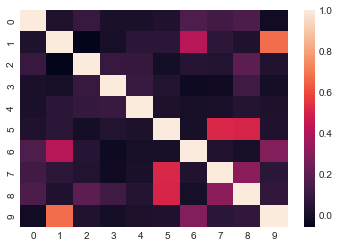

In [63]:
# Let's compute a similarity matrix and see which articles are most similar to each other.
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
sim_mat = pd.DataFrame(similarity).iloc[0:10, 0:10]
sim_full = pd.DataFrame(similarity)
sns.heatmap(sim_mat, yticklabels=range(sim_mat.shape[1]))
plt.show()

In [64]:
# These two should be fairly similar.
print(articles_train[1], '\n\n', articles_train[9])

indonesia sees cpo price rising sharply indonesia expects crude palm oil (cpo) prices to rise sharply to between 450 and 550 dlrs a tonne fob sometime this year because of better european demand and a fall in malaysian output, hasrul harahap, junior minister for tree crops, told indonesian reporters. prices of malaysian and sumatran cpo are now around 332 dlrs a tonne cif for delivery in rotterdam, traders said. harahap said indonesia would maintain its exports, despite making recent palm oil purchases from malaysia, so that it could possibly increase its international market share. indonesia, the world's second largest producer of palm oil after malaysia, has been forced to import palm oil to ensure supplies during the moslem fasting month of ramadan. harahap said it was better to import to cover a temporary shortage than to lose export markets. indonesian exports of cpo in calendar 1986 were 530,500 tonnes, against 468,500 in 1985, according to central bank figures. 

 malaysia may n

Both articles are about palm oil. Very cool. Let's look at some of the BEST matches in the whole data set.

In [65]:
# Remove the 1's from the diagonal and find the remaining max index.
print((sim_full - np.identity(len(sim_full))).idxmax()[:10])

0    463
1     37
2    196
3     99
4    319
5    584
6     81
7    635
8    390
9     37
dtype: int64


In [66]:
items = [0, 463]
print('Similarity:', sim_full.iloc[items[0], items[1]])
print('\n', list(articles_train)[items[0]], '\n\n', list(articles_train)[items[1]])

Similarity: 0.994698885608

 bank of japan satisfied with yen at current range the bank of japan is satisfied with the yen around its current range, a senior central bank official told reporters. he said the pledge by major industrial nations in paris last month to cooperate to hold exchange rates around current ranges applied in both directions, a dollar fall or a dollar rise. unilateral intervention itself cannot ensure currency stability, but it can be useful when coordinated with other policies and with other central banks, he said. the bank of japan is rather confident currency stability will continue for some time, the senior bank official said, but declined to be more specific. finance minister kiichi miyazawa told parliament on friday the current dollar/yen exchange rate is not necessarily satisfactory for the japanese economy. asked what factors might destabilize the markets, the official cited a lessening of market fear about intervention, a completely unexpected change in th

So, this is actually a duplicate of almost exactly the same article. The second example simply has a couple extra sentences added at the end. No wonder they have such a high similarity score!

# Conclusion

Multilabel data is common out in the 'real world', and we've been able to do surprisingly well categorizing it using tfidf with latent semantic analysis and KMeans. With KMeans, we were able to go from a score of 0.54 on the Bag of Words test set with our custom evaluation metric to 0.83 on the tfidf test set. Our model used 32 clusters, and our original data included 15 multilabel categories. Latent semantic analysis did well separating articles by category, and also separated articles by commonalities other than the given categories. This kind of analysis has broad applicability in categorization and tagging of any corpus of articles, memos, or other text documents.